# NLP and Deployment

## Section 0: Data Version Control

Since data is constantly changing, logging the current state of the data is a necessity. It is required that we track the changes and act upon them when necessary, and a prerequisite to knowing when changes occur is to be aware of what changes are logged in our systems and what changes are not. One of the tools used for version controlling the data is `DVC`. Read the documents and use it in the process. Put your DVC data in what you upload.

## Section 1: EDA

You have been given the data containing all papers related to ML, CL, NER, AI and CV field published between 1992 to 2018-Feb. Extract the given dataset, and read it into a `pandas.DataFrame`. Make sure to parse the JSON format correctly.

In [ ]:
import pandas as pd
# Load the dataset
data = pd.read_json("arxivData.json")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41000 entries, 0 to 40999
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   author   41000 non-null  object
 1   day      41000 non-null  int64 
 2   id       41000 non-null  object
 3   link     41000 non-null  object
 4   month    41000 non-null  int64 
 5   summary  41000 non-null  object
 6   tag      41000 non-null  object
 7   title    41000 non-null  object
 8   year     41000 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 2.8+ MB


Plot a bar chart of the columns `day`, `month` and `year`.

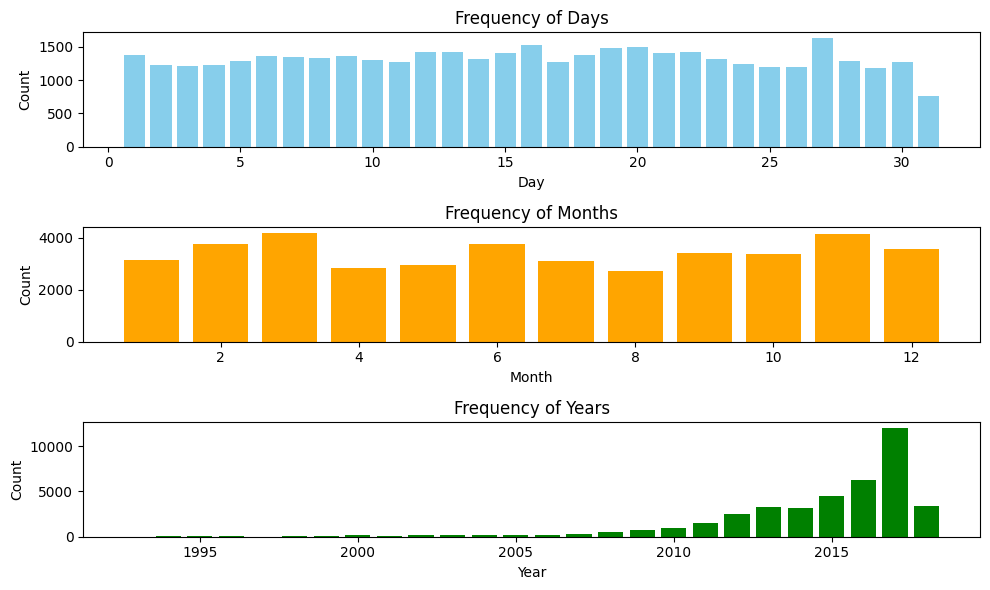

In [ ]:
import matplotlib.pyplot as plt

day_counts = data['day'].value_counts().sort_index()
month_counts = data['month'].value_counts().sort_index()
year_counts = data['year'].value_counts().sort_index()

# Create a figure with subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 6), sharex=False)

# Plot for day
axs[0].bar(day_counts.index, day_counts.values, color='skyblue')
axs[0].set_title('Frequency of Days')
axs[0].set_xlabel('Day')
axs[0].set_ylabel('Count')

# Plot for month
axs[1].bar(month_counts.index, month_counts.values, color='orange')
axs[1].set_title('Frequency of Months')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Count')

# Plot for year
axs[2].bar(year_counts.index, year_counts.values, color='green')
axs[2].set_title('Frequency of Years')
axs[2].set_xlabel('Year')
axs[2].set_ylabel('Count')

# Adjust layout
plt.tight_layout()
plt.show()

Plot a bar plot of the most-reocurring tag terms (for example, *cs.AI*). Articles may have multiple tag terms, so make sure to parse the data correctly.

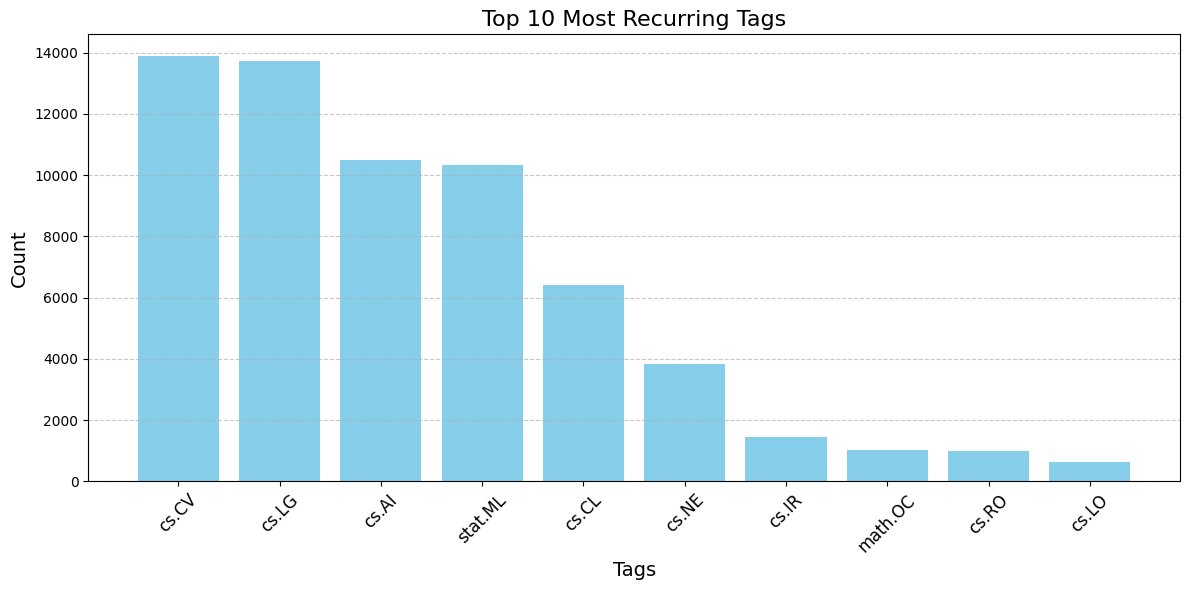

In [ ]:
import ast
from collections import Counter

# Parse the string
def extract_terms(tag_string):
    try:
        tag_list = ast.literal_eval(tag_string)  # Safely parse the string into Python objects
        return [tag['term'] for tag in tag_list if 'term' in tag]  # Extract 'term' values
    except Exception as e:
        print(f"Error parsing row: {e}")
        return []

# extract terms
data['parsed_tags'] = data['tag'].apply(extract_terms)

# Flatten all tags
all_tags = [tag for tags in data['parsed_tags'] for tag in tags]

# Count occurrences
tag_counts = Counter(all_tags)
most_common_tags = tag_counts.most_common(10)  # Get the top 10 tags

# Create a DataFrame
tag_data = pd.DataFrame(most_common_tags, columns=['Tag', 'Count'])

# Plot
plt.figure(figsize=(12, 6))
plt.bar(tag_data['Tag'], tag_data['Count'], color='skyblue')
plt.title('Top 10 Most Recurring Tags', fontsize=16)
plt.xlabel('Tags', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Now, normalize this plot to the total number of articles in each year.

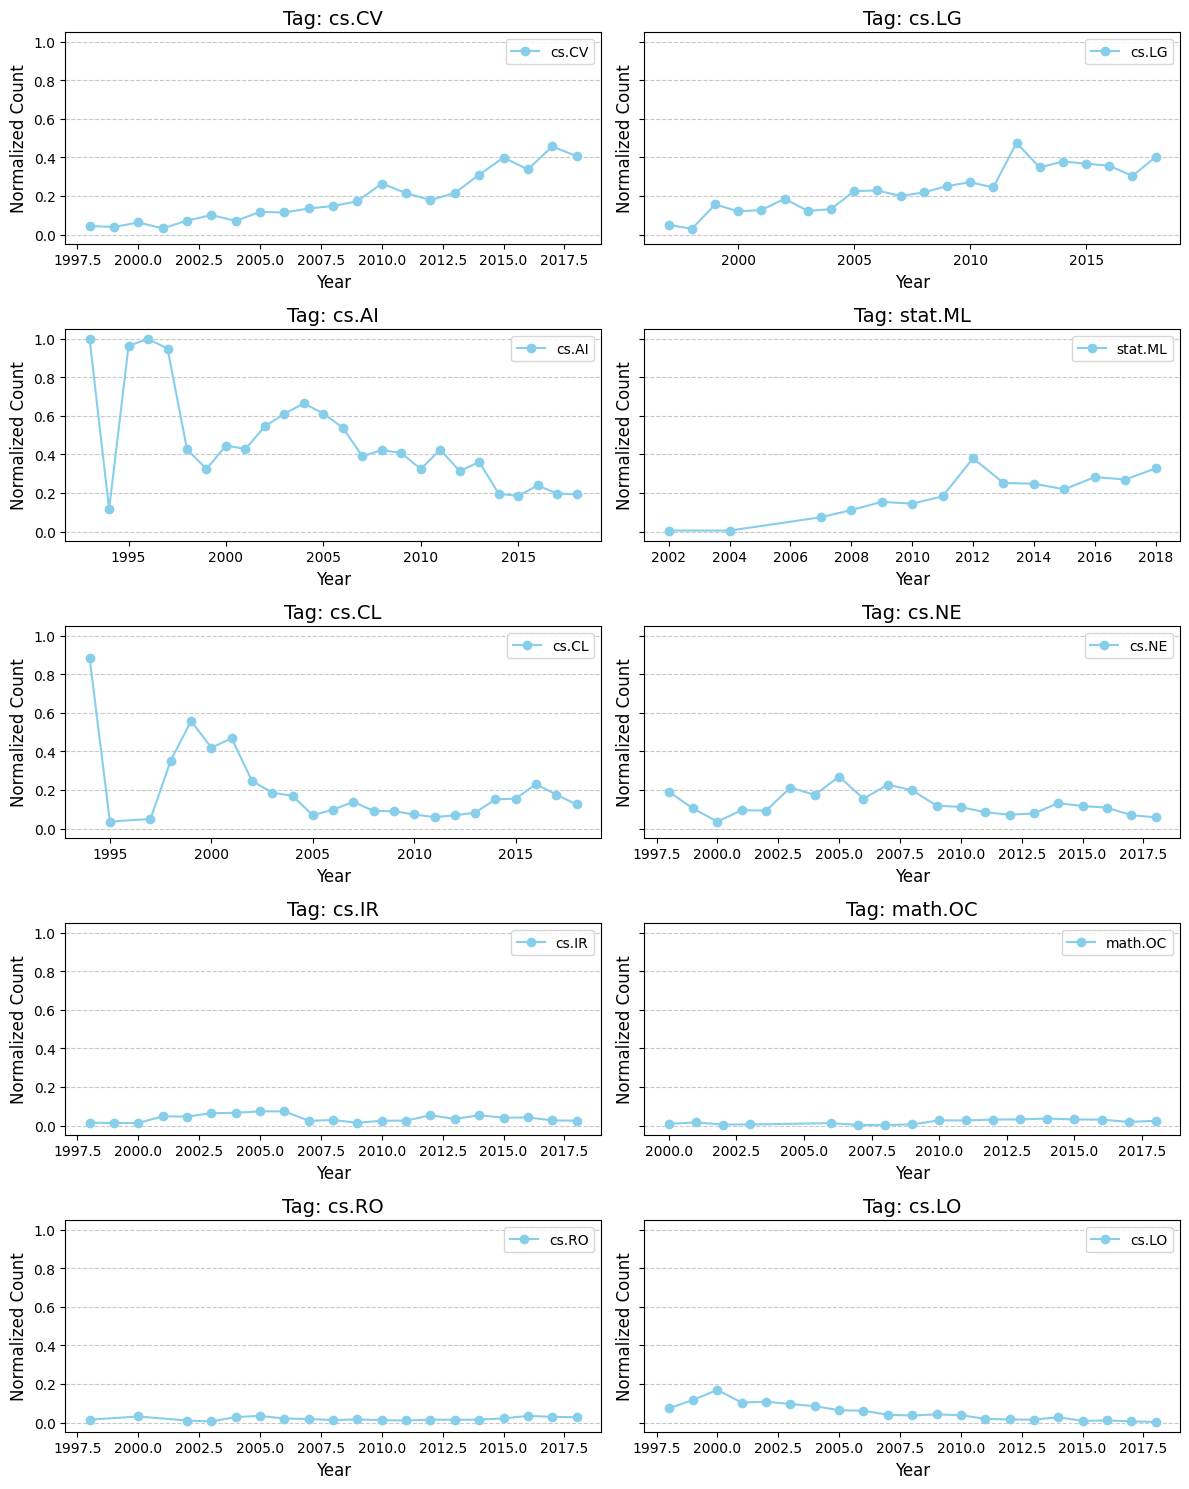

In [ ]:
# Explode tags for easier grouping
data_exploded = data.explode('parsed_tags')

# Group by year and tag, then count
tag_counts_per_year = data_exploded.groupby(['year', 'parsed_tags']).size().reset_index(name='count')

# Calculate total articles per year
total_articles_per_year = data.groupby('year').size().rename('total_articles').reset_index()

# Merge counts with total articles per year
tag_counts_normalized = tag_counts_per_year.merge(total_articles_per_year, on='year')
tag_counts_normalized['normalized_count'] = tag_counts_normalized['count'] / tag_counts_normalized['total_articles']

# Filter the most common tags across all years
most_common_tags = Counter(data_exploded['parsed_tags']).most_common(10)  # Top 10 tags
top_tags = [tag for tag, _ in most_common_tags]
tag_counts_normalized = tag_counts_normalized[tag_counts_normalized['parsed_tags'].isin(top_tags)]

# subplots
n_tags = len(top_tags)
n_cols = 2  # columns
n_rows = (n_tags + n_cols - 1) // n_cols  # rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 3), sharey=True)
axes = axes.flatten()

for i, tag in enumerate(top_tags):
    ax = axes[i]
    tag_data = tag_counts_normalized[tag_counts_normalized['parsed_tags'] == tag]
    ax.plot(tag_data['year'], tag_data['normalized_count'], marker='o', label=tag, color='skyblue')
    ax.set_title(f"Tag: {tag}", fontsize=14)
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Normalized Count', fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.legend(fontsize=10)

# Remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## Section 2: NLP

### 2.1 POS Tagging

Perform POS tagging for 10 samples of `summary` values. You may use libraries such as `spaCy` for POS tagging. Print the POS tagged summaries.

In [ ]:
import spacy

# Load the spaCy English model
nlp = spacy.load("en_core_web_sm")

# Sample data (replace this with 10 summaries from your dataset)
summaries = data['summary'].sample(n=10, random_state=42).tolist()

# Perform POS tagging
for i, summary in enumerate(summaries[:10]):  # Limit to 10 summaries
    print(f"\nSummary {i + 1}:\n{summary}\n")
    doc = nlp(summary)
    print("POS Tagged Summary:")
    for token in doc:
        print(f"{token.text:<15} {token.pos_:<10} {token.tag_:<10}")



Summary 1:
In many physical, statistical, biological and other investigations it is
desirable to approximate a system of points by objects of lower dimension
and/or complexity. For this purpose, Karl Pearson invented principal component
analysis in 1901 and found 'lines and planes of closest fit to system of
points'. The famous k-means algorithm solves the approximation problem too, but
by finite sets instead of lines and planes. This chapter gives a brief
practical introduction into the methods of construction of general principal
objects, i.e. objects embedded in the 'middle' of the multidimensional data
set. As a basis, the unifying framework of mean squared distance approximation
of finite datasets is selected. Principal graphs and manifolds are constructed
as generalisations of principal components and k-means principal points. For
this purpose, the family of expectation/maximisation algorithms with nearest
generalisations is presented. Construction of principal graphs with contr

Plot a histogram of the part of speechs for these 10 samples.

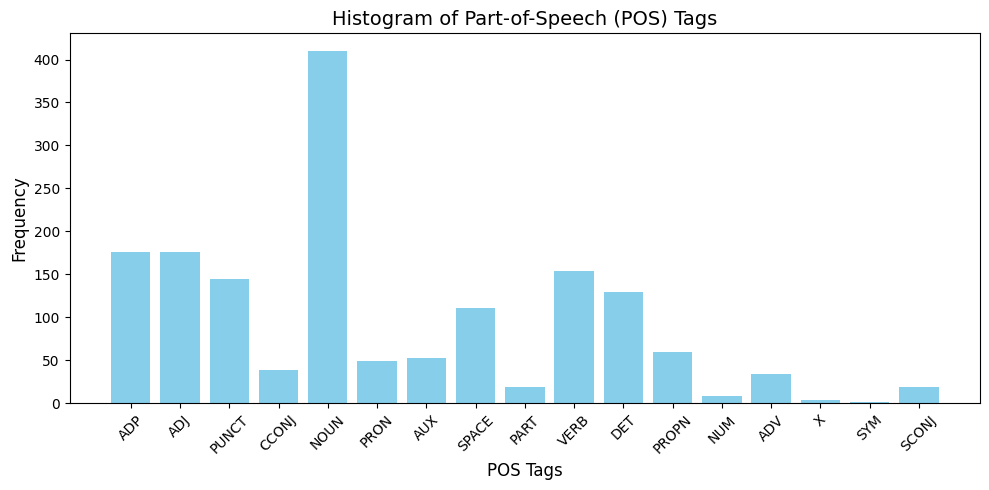

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

pos_counts = Counter()

for summary in summaries:
    doc = nlp(summary)
    pos_counts.update([token.pos_ for token in doc])

# Convert the POS counts to lists\
pos_tags = list(pos_counts.keys())
pos_frequencies = list(pos_counts.values())

# Plot
plt.figure(figsize=(10, 5))
plt.bar(pos_tags, pos_frequencies, color="skyblue")
plt.title("Histogram of Part-of-Speech (POS) Tags", fontsize=14)
plt.xlabel("POS Tags", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 2.2 NER

Perform Name-Entity Recognition for **all** samples of the `summary` data. Try to use `nlp.pipe` so as to only perform NER, as performing `nlp` as a whole on the whole dataset may take too long.

In [ ]:
# Load the spaCy English model properly
nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser"])  # Only enable the NER component

summaries = data['summary'].tolist()

# Use nlp.pipe for batch processing
entities = []
for doc in nlp.pipe(summaries, batch_size=1000):  # Batch processing for efficiency
    doc_entities = [(ent.text, ent.label_) for ent in doc.ents]  # Extract entities and their labels
    entities.append(doc_entities)

# Combine with original
data['entities'] = entities

# Display
for i, row in data.head(10).iterrows():  # Display NER results for the first 10 summaries
    print(f"Summary {i + 1}:\n{row['summary']}\n")
    print(f"Entities: {row['entities']}\n")


c:\Users\HAMAHANG\anaconda3\Lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Summary 1:
We propose an architecture for VQA which utilizes recurrent layers to
generate visual and textual attention. The memory characteristic of the
proposed recurrent attention units offers a rich joint embedding of visual and
textual features and enables the model to reason relations between several
parts of the image and question. Our single model outperforms the first place
winner on the VQA 1.0 dataset, performs within margin to the current
state-of-the-art ensemble model. We also experiment with replacing attention
mechanisms in other state-of-the-art models with our implementation and show
increased accuracy. In both cases, our recurrent attention mechanism improves
performance in tasks requiring sequential or relational reasoning on the VQA
dataset.

Entities: [('VQA', 'ORG'), ('first', 'ORDINAL'), ('VQA', 'ORG'), ('1.0', 'CARDINAL'), ('VQA', 'ORG')]

Summary 2:
Recent approaches based on artificial neural networks (ANNs) have shown
promising results for short-text classifi

Get all the NER tag types (such `ORDINAL`, `CARDINAL`, etc). Plot a bar chart of it.

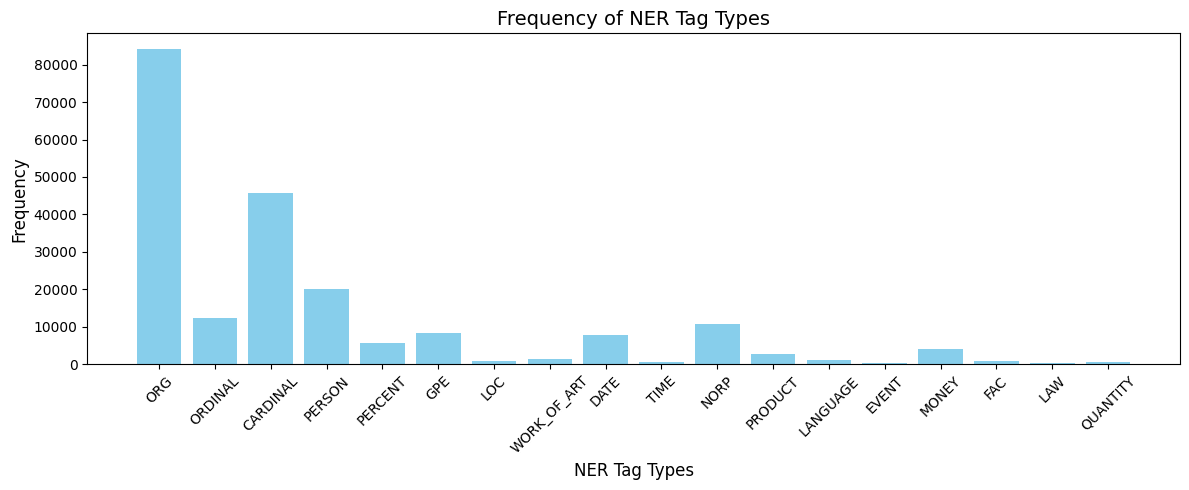

In [ ]:
# Flatten the list of entities from all summaries into a single list of entity labels
all_ner_labels = [label for entity_list in data['entities'] for _, label in entity_list]

# Count the frequencies
ner_label_counts = Counter(all_ner_labels)

# List
labels = list(ner_label_counts.keys())
frequencies = list(ner_label_counts.values())

# Plot
plt.figure(figsize=(12, 5))
plt.bar(labels, frequencies, color="skyblue")
plt.title("Frequency of NER Tag Types", fontsize=14)
plt.xlabel("NER Tag Types", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()


Find all the unique tag types. Plot the top 10 most frequent names for each NER tag type.

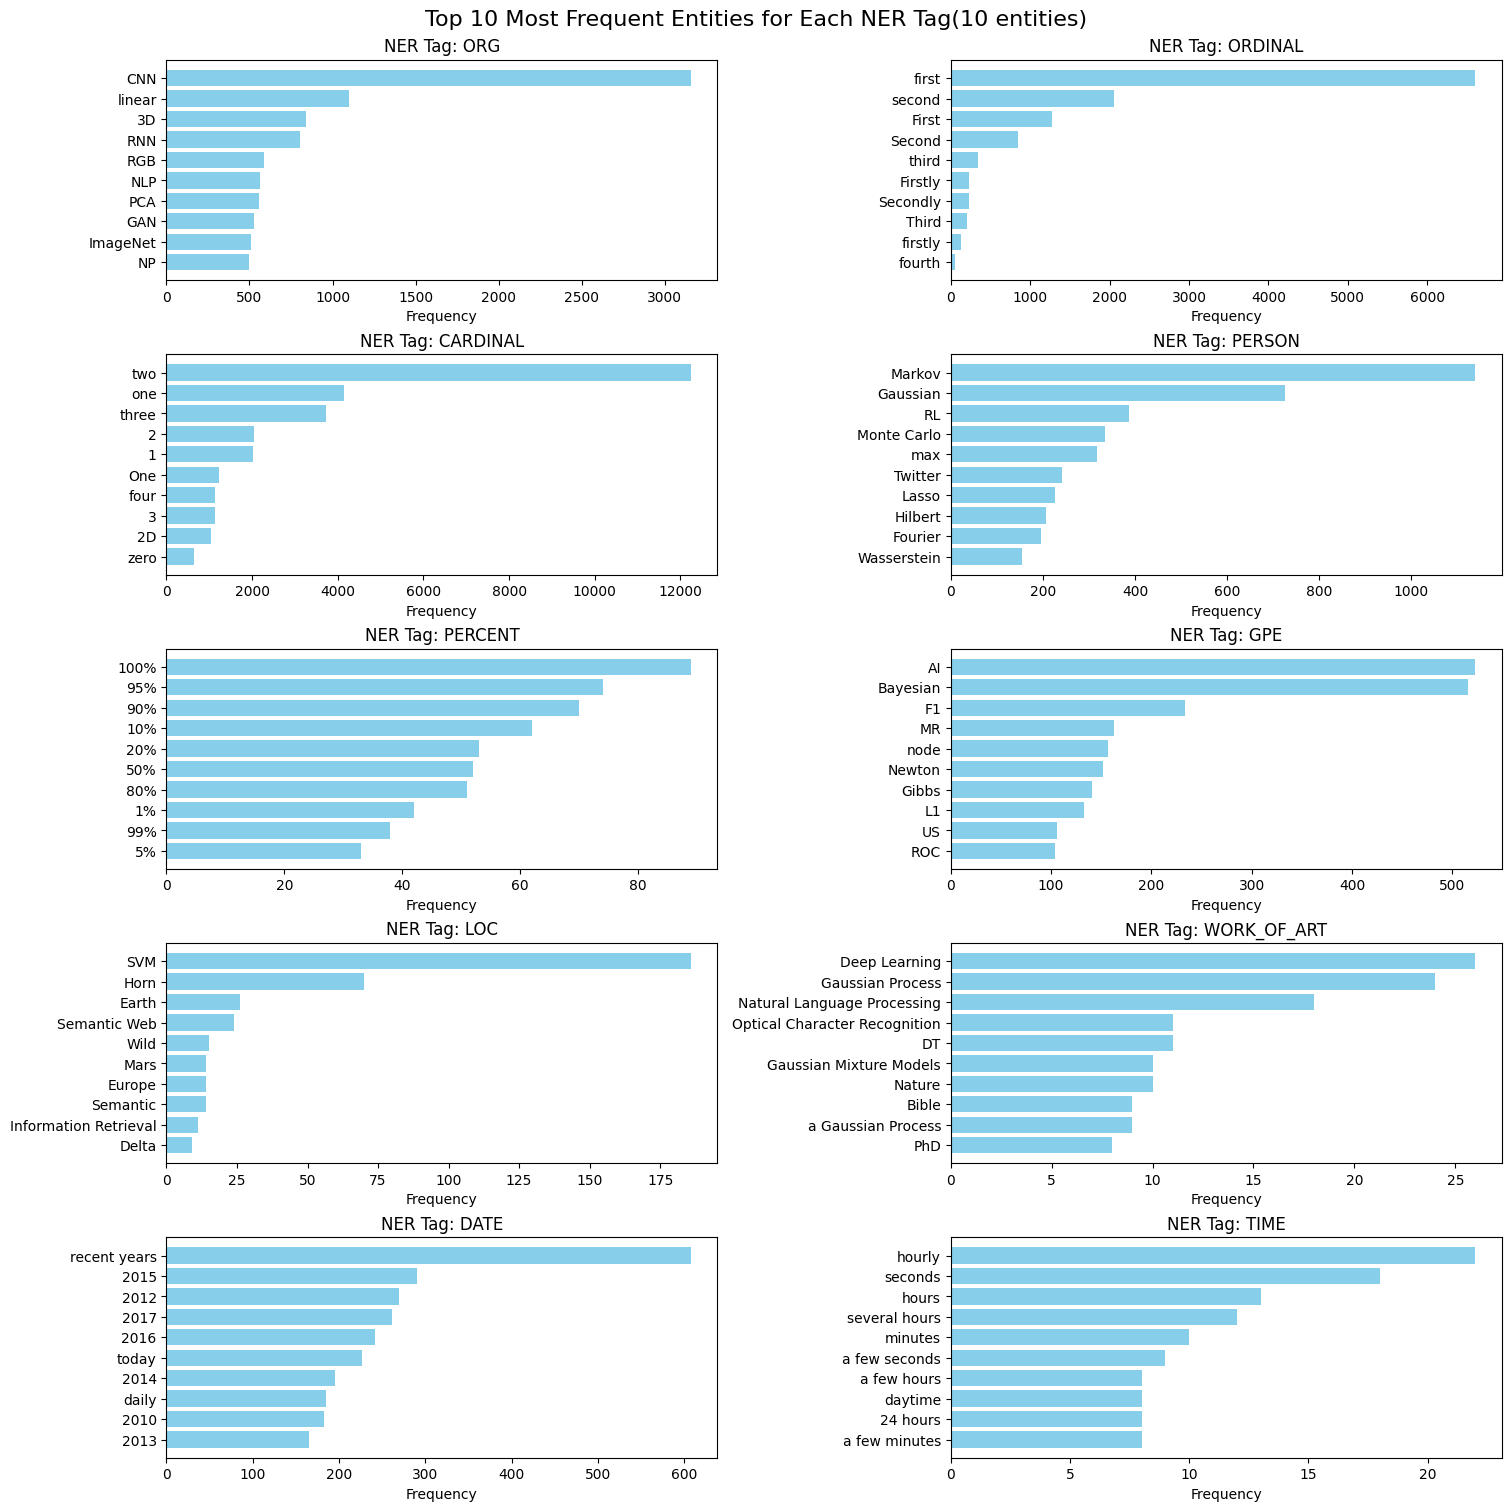

In [ ]:
# Flatten the entities and organize them by tag type
tagged_entities = {}
for entity_list in data['entities']:
    for entity, label in entity_list:
        if label not in tagged_entities:
            tagged_entities[label] = []
        tagged_entities[label].append(entity)

# Get the top 10 most frequent names for each NER tag type
top_entities_by_tag = {}
for tag, entities in tagged_entities.items():
    entity_counts = Counter(entities)  # Count occurrences of each entity
    top_entities_by_tag[tag] = entity_counts.most_common(10)  # Get top 10

# Plot
n = len(frequencies)
fig, axes = plt.subplots(5, 2, figsize=(15, 15), constrained_layout=True)
axes = axes.flatten()

for idx, (tag, top_entities) in enumerate(top_entities_by_tag.items()):
    if idx < 10:
        names, counts = zip(*top_entities)
        axes[idx].barh(names, counts, color="skyblue")
        axes[idx].set_title(f"NER Tag: {tag}", fontsize=12)
        axes[idx].set_xlabel("Frequency", fontsize=10)
        axes[idx].invert_yaxis()

for idx in range(len(top_entities_by_tag), len(axes)):
    axes[idx].axis("off")

# title
fig.suptitle("Top 10 Most Frequent Entities for Each NER Tag(10 entities)", fontsize=16)
plt.show()

Based on these observations, how well is the `spaCy` NER tagging performing on this dataset?

- **Strengths**:
    1. **Tagging Variety**:
    - `spaCy` effectively identifies a wide range of NER tag types, such as $\texttt{ORG}$, $\texttt{PERSON}$, $\texttt{DATE}$, $\texttt{TIME}$, and $\texttt{PERCENT}$, demonstrating its versatility.

    1. **Meaningful Entities**:
    - Many extracted entities, such as "CNN," "GAN," and "ImageNet" under $\texttt{ORG}$, and "Markov" and "Gaussian" under $\texttt{PERSON}$, are relevant to a dataset of academic papers.

    1. **Accurate Grouping**:
    - Terms like "2015" and "2022" under $\texttt{DATE}$, or $100\%$ and $90\%$ under $\texttt{PERCENT}$, are correctly categorized, showcasing reliable extraction for numeric entities.

    1. **Consistent Frequency Trends**:
    - Frequent use of numbers like "two" and "three" under $\texttt{CARDINAL}$ is typical for texts describing datasets, methods, or results.

- **Weaknesses**:
  1. **Misclassification**:
     - Terms such as "Monte Carlo" and "Twitter" are misclassified under $\texttt{PERSON}$, indicating occasional errors in context recognition.
     - Entities like "Natural Language Processing" under $\texttt{WORK\_OF\_ART}$ might be better classified under $\texttt{ORG}$ or $\texttt{LOC}$.

  2. **Ambiguity in Labels**:
     - $\texttt{spaCy}$ struggles with terms that have multiple interpretations. For example, "GAN" as $\texttt{ORG}$ might not represent an organization but rather a concept ("Generative Adversarial Network").

  3. **Over-simplified Labels**:
     - Some entities (e.g., "2D" and "3D" under $\texttt{CARDINAL}$) could benefit from more domain-specific labels, such as $\texttt{TECHNICAL\_TERM}$.


Find the top 10 most frequent names in general.

Top 10 Most Frequent Entity Names:
two: 12250
first: 6606
one: 4147
three: 3731
CNN: 3160
Bayesian: 2910
1: 2058
second: 2054
2: 2047
Gaussian: 1749


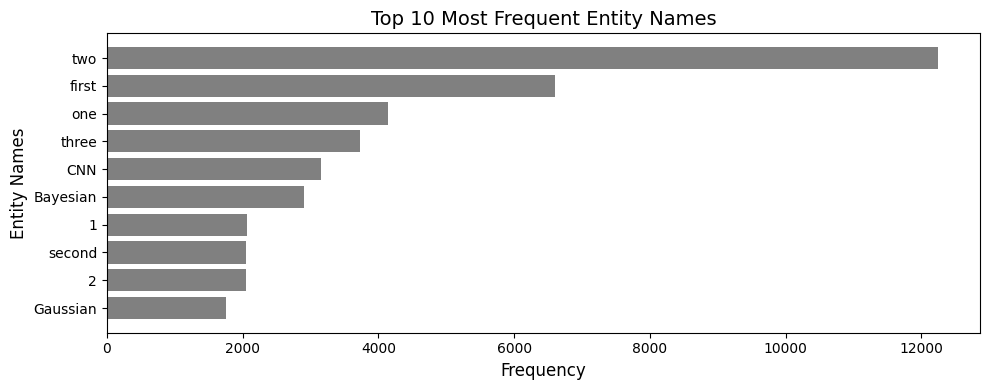

In [ ]:
# Flatten
all_entities = [entity for entity_list in data['entities'] for entity, _ in entity_list]

# Count
entity_counts = Counter(all_entities)

# top 10 most frequent entity names
top_10_entities = entity_counts.most_common(10)

# Display
print("Top 10 Most Frequent Entity Names:")
for name, count in top_10_entities:
    print(f"{name}: {count}")

# Plot
names, counts = zip(*top_10_entities)
plt.figure(figsize=(10, 4))
plt.barh(names, counts, color="grey")
plt.title("Top 10 Most Frequent Entity Names", fontsize=14)
plt.xlabel("Frequency", fontsize=12)
plt.ylabel("Entity Names", fontsize=12)
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.tight_layout()
plt.show()


### 2.3 Embeddings

#### BoW

Use BoW (`sklearn.feature_extraction.text.CountVectorizer`) on `summary` to train a regression model, and choose `year` to be your label. What type of transformation will you choose for changing `year` to be a meaningful label?


Before training your model, you should do some pre-processing, in an attempt to extract useful features from the text. First, use `nltk` to remove the stopwords, and remove all the punctuations. Then use lemmatization on the text to convert them to their base forms.

You are allowed to use a subset of the data.

Since `year` is numerical, it can directly serve as a regression label.

In [ ]:
import re
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# download
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

def preprocess_text(text):
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in text.split() if word not in stop_words]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

data['summary_cleaned'] = data['summary'].apply(preprocess_text)

data_sampled = data.sample(frac=0.5, random_state=42)

# Features and labels
X = data_sampled['summary_cleaned']
y = data_sampled['year']

# Convert text to BoW features
vectorizer = CountVectorizer(max_features=1000)
X_bow = vectorizer.fit_transform(X)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HAMAHANG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HAMAHANG\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\HAMAHANG\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Now, train an appropriate regression model on this data. Report the test set (X and y), and the estimation of your model together. Report the RMSE of the model too.

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Split
X_train, X_test, y_train, y_test = train_test_split(X_bow, y, test_size=0.2, random_state=42)

# Train the model
regressor = Ridge(max_iter=1000)
regressor.fit(X_train, y_train)

# Predictions
y_pred = regressor.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

Mean Squared Error: 10.42
Root Mean Squared Error: 3.23


Does your error make sense in the context of the data?

- **Summery**:

1. **MSE**:
   - Measures the average squared difference between the predicted and actual year values.
   - Larger errors contribute more heavily due to the squaring.

2. **RMSE**:
   - Indicates that, on average, the model's predictions are off by approximately **3.23 years**.
   - More interpretable than MSE since it is in the same unit as the target variable ($\text{year}$).

- **Suggestions for Improvement**:

   1. **Feature Engineering**:
      - Use **TF-IDF (Term Frequency-Inverse Document Frequency)** to improve word importance capturing:
        $$
        \text{TF-IDF}(t, d) = \text{TF}(t, d) \times \text{IDF}(t)
        $$
        Where:
        - $\text{TF}(t, d)$ = Frequency of term $t$ in document $d$.
        - $\text{IDF}(t) = \log\frac{N}{1 + n_t}$, where $N$ is the total number of documents, and $n_t$ is the number of documents containing $t$.

      1. **Hyperparameter Tuning**:
         - Use **GridSearchCV** to find the optimal regularization parameter ($\alpha$) in Ridge Regression:
           $$
           \min_{\beta} \| X\beta - y \|^2 + \alpha \| \beta \|^2
           $$

      2. **Test Other Models**:
         - Explore non-linear models such as:
           - Random Forest Regressor
           - Gradient Boosting Regressor
           - Neural Networks.

      3. **Ensemble Models**:
         - Combine predictions from multiple models:
           $$
           \hat{y}_{\text{final}} = \frac{1}{k} \sum_{i=1}^{k} \hat{y}_i
           $$
           Where $k$ is the number of models.

      4. **Data Augmentation**:
         - Enhance textual variability using techniques such as:
           - Synonym replacement.
           - Paraphrasing.


#### TF-IDF

Repeat the same procedure on your cleaned data on the same model algorithm, but this time use TF-IDF embedding for the training data.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

X = tfidf_vectorizer.fit_transform(data_sampled['summary_cleaned'])

# label
y = data_sampled['year']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = Ridge()
model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = model.predict(X_test)

# Calculate Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

Mean Squared Error: 9.62
Root Mean Squared Error: 3.10


Did your error improve? Why?

Yes, It Did. Let's delve into details:

**Improvement with TF-IDF**:

   - TF-IDF embedding resulted in a lower MSE (\(9.62\)) compared to BoW (\(10.42\)).
   - Similarly, RMSE improved from \(3.23\) (BoW) to \(3.10\) (TF-IDF).
   - This suggests that TF-IDF provides a more meaningful representation of the text for this regression task, likely because it accounts for the importance of words in the document relative to the entire corpus.

**Why TF-IDF Performed Better**

- **TF-IDF**:
  - Weights words based on their importance in a document relative to the entire corpus.
  - Reduces the impact of common words (e.g., stopwords) and emphasizes rare but meaningful terms.
  - This weighting scheme likely helped the regression model better capture patterns related to the `year` label.

- **BoW**:
  - Treats all words equally, regardless of their importance.
  - May include noise from common words, which can dilute the signal for the regression task.


#### GLoVe

This time use the GloVe embedding to train your model, and repeat the same steps as before.

**Downloading GloVe**:

The original GloVe embeddings come in various dimensions, with the most common ones being 50-dimensional and 100-dimensional. The 50-dimensional version is smaller and requires less memory, making it a good choice if we are working with limited resources. There are multiple options on where to download GloVe:

1. **Stanford NLP Website**: Visit the [GloVe page on Stanford NLP's website](https://nlp.stanford.edu/projects/glove/). Scroll down to the section "Download pre-trained word vectors" and download the glove.6B.zip file.
2. **From Kaggle**: Go to [Kaggle's GloVe 50D dataset](https://www.kaggle.com/datasets/rtatman/glove-global-vectors-for-word-representation) page. Click on the "Download" button to get the file.
3. `torchtext.vocab.GloVe(name="6B", dim=50, max_vectors=20_000)`

In [ ]:
import re
import numpy as np
import torch
import torchtext.vocab as vocab
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Load GloVe embeddings
# glove = vocab.GloVe(name="6B", dim=50, max_vectors=20_000)

# Convert text to GloVe embeddings
def text_to_glove_embedding(words):
    embeddings = []
    for word in words:
        if word in glove.stoi:  # Check if word is in GloVe vocabulary
            embeddings.append(glove.vectors[glove.stoi[word]].numpy())  # Convert to numpy array
    if len(embeddings) > 0:
        return np.mean(embeddings, axis=0)  # Average embeddings
    else:
        return np.zeros(glove.dim)  # Return zero vector if no words are found

# Apply GloVe
X_glove = np.array([text_to_glove_embedding(words) for words in data_sampled['summary_cleaned']])
y = data_sampled['year']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_glove, y, test_size=0.2, random_state=42)

# Train the model
regressor = Ridge(max_iter=1000)
regressor.fit(X_train, y_train)

# Predictions
y_pred = regressor.predict(X_test)

# Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

# Root Mean Squared Error
rmse = np.sqrt(mse)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

Mean Squared Error: 12.49
Root Mean Squared Error: 3.53


##### Embeddings rich with semantics

It seems that the GloVe embedding captures some of the semantic relationship in its embeddings, and we are going to put that to the test.

Firstly, we define the *cosine similarity* as:

$$
\cos{\theta} = \frac{A\cdot B}{\Vert A \Vert \Vert B \Vert}
$$

Where $A$ and $B$ are vectors. Let $E(W)$ denote the embedding of the word $W$. We want to see if the following relationship holds true:

$$
E(\text{woman})-E(\text{man}) + E(\text{king}) \approx^? E(\text{queen})
$$

For this, find the most similar vector to $[E(\text{woman})-E(\text{man}) + E(\text{king})]$ using the cosine similarity metric in the GloVe corpus, and see if it equals to `queen`.

In [ ]:
import torch

# Load GloVe embeddings
# glove = vocab.GloVe(name="6B", dim=50, max_vectors=20_000)

# Function to compute cosine similarity
def cosine_similarity(vec1, vec2):
    return torch.dot(vec1, vec2) / (torch.norm(vec1) * torch.norm(vec2))

# Retrieve embeddings for 'woman', 'man', 'king', and 'queen'
woman = glove['woman']
man = glove['man']
king = glove['king']
queen = glove['queen']

# Compute the vector V = E(woman) - E(man) + E(king)
V = woman - man + king

# Find the most similar word to V in the GloVe vocabulary
max_similarity = -1
most_similar_word = None

for word, embedding in glove.stoi.items():
    embedding_vector = glove.vectors[embedding]
    similarity = cosine_similarity(V, embedding_vector)
    if similarity > max_similarity:
        max_similarity = similarity
        most_similar_word = word

# Check if the most similar word is 'queen'
print(f"Most similar word to [E(woman) - E(man) + E(king)]: {most_similar_word} with similarity : {similarity}")
print(f"Is the most similar word 'queen'? {most_similar_word == 'queen'}")

Most similar word to [E(woman) - E(man) + E(king)]: king with similarity : 0.11123242229223251
Is the most similar word 'queen'? False


This shows that the vector $[E(\text{woman})-E(\text{man})]$ captures some semantic information about *femininity*. Now, we want to see what the *feminine* version of the words given to you below is.

For each word given below, find their feminine version using the GloVe embedding.

In [ ]:
# words to find feminine versions
words = [
    "actor", "prince", "king", "waiter", "host",
    "bridegroom", "bachelor", "god", "hero", "emperor",
    "duke", "sir", "father", "uncle", "brother",
    "dog", "bull", "lion", "warrior", "wizard",
    "knight", "hunter", "boy", "son", "grandfather"
]

# Compute the gender vector: E(woman) - E(man)
woman = glove['woman']
man = glove['man']
gender_vector = woman - man

# Function to find the most similar word
def find_most_similar_word(vector, glove):
    max_similarity = -1
    most_similar_word = None
    for word, embedding in glove.stoi.items():
        embedding_vector = glove.vectors[embedding]
        similarity = cosine_similarity(vector, embedding_vector)
        if similarity > max_similarity:
            max_similarity = similarity
            most_similar_word = word
    return most_similar_word

# Find feminine versions for each word
feminine_versions = {}
for word in words:
    if word in glove.stoi:
        word_embedding = glove[word]
        feminine_embedding = word_embedding + gender_vector
        feminine_word = find_most_similar_word(feminine_embedding, glove)
        feminine_versions[word] = feminine_word
    else:
        feminine_versions[word] = None  # Word not in GloVe vocabulary


for word, feminine_word in feminine_versions.items():
    print(f"Masculine: {word} -> Feminine: {feminine_word}")

Masculine: actor -> Feminine: actress
Masculine: prince -> Feminine: prince
Masculine: king -> Feminine: king
Masculine: waiter -> Feminine: None
Masculine: host -> Feminine: host
Masculine: bridegroom -> Feminine: None
Masculine: bachelor -> Feminine: bachelor
Masculine: god -> Feminine: god
Masculine: hero -> Feminine: hero
Masculine: emperor -> Feminine: emperor
Masculine: duke -> Feminine: duke
Masculine: sir -> Feminine: sir
Masculine: father -> Feminine: mother
Masculine: uncle -> Feminine: aunt
Masculine: brother -> Feminine: daughter
Masculine: dog -> Feminine: dog
Masculine: bull -> Feminine: bull
Masculine: lion -> Feminine: lion
Masculine: warrior -> Feminine: warrior
Masculine: wizard -> Feminine: wizard
Masculine: knight -> Feminine: knight
Masculine: hunter -> Feminine: hunter
Masculine: boy -> Feminine: girl
Masculine: son -> Feminine: daughter
Masculine: grandfather -> Feminine: grandmother


##### Orthogonality

Now we want to see if seemingly unrelated words that contain unrelated semantic information have embedding vectors that are orthogonal to each other. This means their cosine similarity should be close to zero; meaning that $\theta$ in $\cos{\theta}$ should be close to $90\degree$.

Find the angle $\theta$ between these unrelated pairs of words, given to you below.

In [ ]:
# unrelated word pairs (hopefully)
unrelated_pairs = [
    ("apple", "democracy"),
    ("bottle", "philosophy"),
    ("guitar", "justice"),
    ("ocean", "mathematics"),
    ("table", "happiness"),
    ("elephant", "quantum"),
    ("bread", "government"),
    ("television", "ethics"),
    ("car", "freedom"),
    ("flower", "economy")
]

# Function to compute cosine similarity
def cosine_similarity(vec1, vec2):
    return torch.dot(vec1, vec2) / (torch.norm(vec1) * torch.norm(vec2))

# Compute cosine similarity and angle θ for each pair
results = []
for word1, word2 in unrelated_pairs:
    if word1 in glove.stoi and word2 in glove.stoi:
        vec1 = glove[word1]
        vec2 = glove[word2]
        similarity = cosine_similarity(vec1, vec2).item()
        theta = np.arccos(similarity) * (180 / np.pi)  # Convert radians to degrees
        results.append((word1, word2, similarity, theta))
    else:
        results.append((word1, word2, None, None))  # Handle out-of-vocabulary words

# Print results
print(f"{'Word 1':<15} {'Word 2':<15} {'Cosine Similarity':<20} {'Angle θ (degrees)':<20}")
for word1, word2, similarity, theta in results:
    if similarity is not None:
        print(f"{word1:<15} {word2:<15} {similarity:<20.4f} {theta:<20.4f}")
    else:
        print(f"{word1:<15} {word2:<15} {'N/A':<20} {'N/A':<20}")

Word 1          Word 2          Cosine Similarity    Angle θ (degrees)   
apple           democracy       0.1659               80.4516             
bottle          philosophy      0.0726               85.8361             
guitar          justice         0.0849               85.1315             
ocean           mathematics     0.0862               85.0527             
table           happiness       0.2744               74.0757             
elephant        quantum         -0.0984              95.6485             
bread           government      0.1895               79.0762             
television      ethics          0.2173               77.4512             
car             freedom         0.2304               76.6765             
flower          economy         0.1589               80.8555             


##### Orthogonality and dimensionality

It seems that different semantics try to encode themselves perpendicular to each other. These vectors are not *perfectly* orthogonal, but rather *almost* orthogonal; because perfect orthogonality limits the number of vectors to the number of dimensions $N$. We are interested in seeing how by increasing dimensionality we can help the model capture more semantics, i.e give it more room for *almost* orthogonal vectors.

Generate 10,000 random vectors of dimension 50, and 100 (you may want to use `torch.randn`, you will need it later). You can already see that 10,000 is much larger than the number of dimensions. Calculate the pair-wise cosine similarity for each of them. Then, plot a bar chart of the angle between them in **degrees**.

GPU is available! Using GPU.


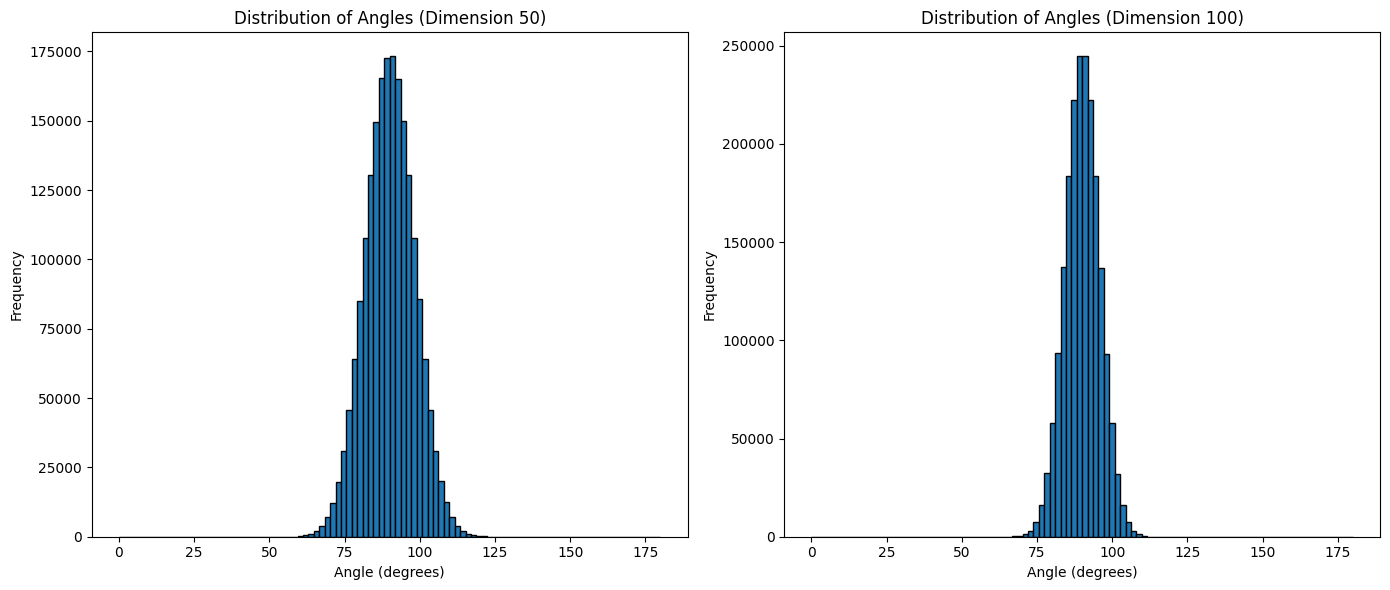

In [27]:
import re
import numpy as np
import torch
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt


# Set random seed for reproducibility
# torch.manual_seed(42)

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available! Using GPU.")
else:
    device = torch.device("cpu")
    print("GPU not available. Using CPU.")

# Generate random vectors
num_vectors = 2_000
dim_50 = 50
dim_100 = 100

# Generate 10,000 random vectors of dimensions 50 and 100
vectors_50 = torch.randn(num_vectors, dim_50)
vectors_100 = torch.randn(num_vectors, dim_100)

# Function to compute pairwise cosine similarity and angles
def compute_angles(vectors):
    num_vectors = vectors.shape[0]
    angles = []

    # pairwise similarity
    for i in range(num_vectors):
        for j in range(i + 1, num_vectors):
            vec1 = vectors[i]
            vec2 = vectors[j]
            cosine_sim = torch.dot(vec1, vec2) / (torch.norm(vec1) * torch.norm(vec2))
            angle_rad = torch.acos(torch.clamp(cosine_sim, -1.0, 1.0))  # Clamp to avoid numerical errors
            angle_deg = torch.rad2deg(angle_rad).item()
            angles.append(angle_deg)

    return angles

# Compute angles
angles_50 = compute_angles(vectors_50)
angles_100 = compute_angles(vectors_100)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for dimension 50
axes[0].hist(angles_50, bins=100, range=(0, 180), edgecolor='black')
axes[0].set_title("Distribution of Angles (Dimension 50)")
axes[0].set_xlabel("Angle (degrees)")
axes[0].set_ylabel("Frequency")

# Plot for dimension 100
axes[1].hist(angles_100, bins=100, range=(0, 180), edgecolor='black')
axes[1].set_title("Distribution of Angles (Dimension 100)")
axes[1].set_xlabel("Angle (degrees)")
axes[1].set_ylabel("Frequency")

# Adjust layout and display the plot
plt.tight_layout()

Now we intend on making these random vectors more orthogonal to each other. We will write a torch program to achieve this.

1. Normalize the vectors.
2. Set the optimizer and its optimizing target, learning rate, number of epochs, etc.
3. Create a loss function that incentivizes orthogonality. We can begin with the observation that if the matrix of your random vectors is $A$, $AA^T$ is a big matrix of dot products (we choose $AA^T$ instead of $A^TA$ because that is the bigger matrix). Since your vectors are normalized, ideally this matrix should be $I$; therefore a good choice for the loss function is summing over the elements of $AA^T - I$. More specifically, the sum of the *absolute values*. You can add extra motivation by adding the higher powers of $\text{diag}(AA^T - I)$.
4. You might need a cut-off and an activation function for the loss function.
5. Run the optimization. Plot your ending results.
6. Do this for both 50 and 100 dimensions.

Optimizing vectors of dimension 50...
Epoch [10/100], Loss: 443196.0625
Epoch [20/100], Loss: 429862.0312
Epoch [30/100], Loss: 402871.1875
Epoch [40/100], Loss: 359810.9375
Epoch [50/100], Loss: 309035.4688
Epoch [60/100], Loss: 263383.3438
Epoch [70/100], Loss: 226687.4375
Epoch [80/100], Loss: 198953.9688
Epoch [90/100], Loss: 177852.3594
Epoch [100/100], Loss: 161941.7500
Optimizing vectors of dimension 100...
Epoch [10/100], Loss: 305271.1875
Epoch [20/100], Loss: 293514.8750
Epoch [30/100], Loss: 269189.1250
Epoch [40/100], Loss: 230492.8438
Epoch [50/100], Loss: 188253.8438
Epoch [60/100], Loss: 153863.5000
Epoch [70/100], Loss: 128545.6719
Epoch [80/100], Loss: 110188.2500
Epoch [90/100], Loss: 96966.6094
Epoch [100/100], Loss: 87364.0000


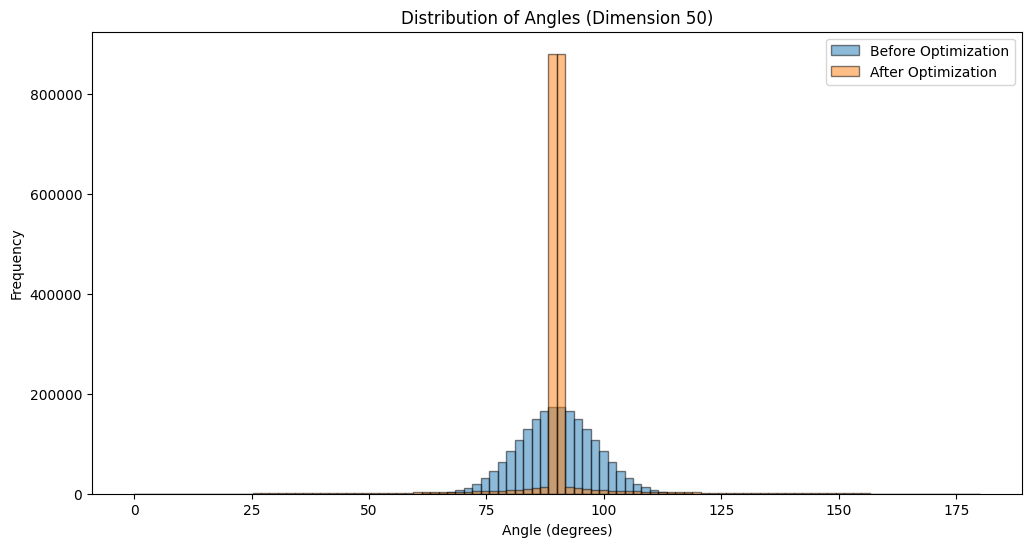

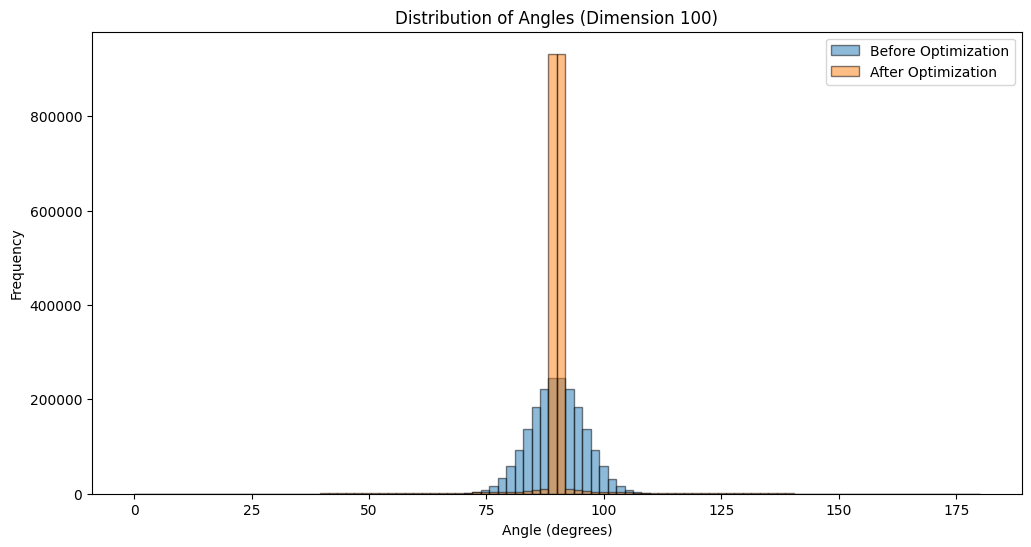

In [29]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

# Parameters
learning_rate = 0.01
num_epochs = 100

# Function to normalize vectors
def normalize_vectors(vectors):
    return vectors / torch.norm(vectors, dim=1, keepdim=True)

# Loss function
def orthogonality_loss(matrix):
    # Compute AA^T
    aat = torch.matmul(matrix, matrix.T)
    # Compute AA^T - I
    identity = torch.eye(matrix.size(0))
    diff = aat - identity
    # Sum of absolute values of off-diagonal elements
    off_diag_loss = torch.sum(torch.abs(diff)) - torch.sum(torch.abs(torch.diag(diff)))
    # Add higher powers of diagonal elements for regularization
    diag_loss = torch.sum(torch.pow(torch.diag(diff), 2))
    return off_diag_loss + diag_loss

# Function to optimize vectors
def optimize_vectors(vectors, learning_rate, num_epochs):
    vectors = vectors.clone().requires_grad_(True)
    optimizer = optim.Adam([vectors], lr=learning_rate)

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        loss = orthogonality_loss(vectors)
        loss.backward()
        optimizer.step()
        # Re-normalize vectors after each step
        with torch.no_grad():
            vectors.data = normalize_vectors(vectors.data)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

    return vectors

# Normalize initial vectors
vectors_50 = normalize_vectors(vectors_50)
vectors_100 = normalize_vectors(vectors_100)

# Optimize vectors
print("Optimizing vectors of dimension 50...")
optimized_vectors_50 = optimize_vectors(vectors_50, learning_rate, num_epochs)

print("Optimizing vectors of dimension 100...")
optimized_vectors_100 = optimize_vectors(vectors_100, learning_rate, num_epochs)

# Function to compute pairwise angles
def compute_angles(vectors):
    num_vectors = vectors.size(0)
    angles = []
    for i in range(num_vectors):
        for j in range(i + 1, num_vectors):
            vec1 = vectors[i]
            vec2 = vectors[j]
            cosine_sim = torch.dot(vec1, vec2) / (torch.norm(vec1) * torch.norm(vec2))
            angle_rad = torch.acos(torch.clamp(cosine_sim, -1.0, 1.0))
            angle_deg = torch.rad2deg(angle_rad).item()
            angles.append(angle_deg)
    return angles

# Compute angles before and after optimization
angles_50_before = angles_50
angles_50_after = compute_angles(optimized_vectors_50)

angles_100_before = angles_100
angles_100_after = compute_angles(optimized_vectors_100)

# Plot results
def plot_angle_distribution(angles_before, angles_after, title):
    plt.figure(figsize=(12, 6))
    plt.hist(angles_before, bins=100, range=(0, 180), alpha=0.5, label="Before Optimization", edgecolor='black')
    plt.hist(angles_after, bins=100, range=(0, 180), alpha=0.5, label="After Optimization", edgecolor='black')
    plt.title(title)
    plt.xlabel("Angle (degrees)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

# Plot for dimension 50
plot_angle_distribution(angles_50_before, angles_50_after, "Distribution of Angles (Dimension 50)")

# Plot for dimension 100
plot_angle_distribution(angles_100_before, angles_100_after, "Distribution of Angles (Dimension 100)")

Find how many of these vectors are *almost* orthogonal to every other vector. We define *almost* orthogonal as having a cosine similarity with every other vector in the range $90\degree \pm \epsilon$. Choose $\epsilon = 1\degree$.

In [38]:
epsilon = 1  # 1 degree

# Function to count almost orthogonal vectors
def count_almost_orthogonal_vectors(angles, epsilon):
    angles = torch.tensor(angles)  # Convert the list to a PyTorch tensor
    almost_orthogonal_count = 0

    # Count angles close to 90° ± epsilon
    almost_orthogonal_count = torch.sum((angles >= 90 - epsilon) & (angles <= 90 + epsilon)).item()

    return almost_orthogonal_count

# Count almost orthogonal vectors
almost_orthogonal_50 = count_almost_orthogonal_vectors(angles_50_after, epsilon)
almost_orthogonal_100 = count_almost_orthogonal_vectors(angles_100_after, epsilon)

# Print results
print(f"Number of almost orthogonal vectors (Dimension 50): {almost_orthogonal_50}")
print(f"Number of almost orthogonal vectors (Dimension 100): {almost_orthogonal_100}")

Number of almost orthogonal vectors (Dimension 50): 1726372
Number of almost orthogonal vectors (Dimension 100): 1844754


## Section 3: Deployment

### AutoML

Use a fitting embedding technique and preprocess your data accordingly. Perform the train/test splitting.

In [ ]:
# We used variables of previous section to avoid re-computing
# Apply GloVe 
limit = len(data_sampled['summary_cleaned'])//5 # 10% of raw data
X_glove = np.array([text_to_glove_embedding(words) for words in data_sampled['summary_cleaned'][:limit]])
y = data_sampled['year'][:limit]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_glove, y, test_size=0.2, random_state=42)

Now we inted to use `H2O` for AutoML. You may use resources such as Google Colab or Kaggle to circumvent the download sizes. You still need to push your model to DVC, so do it from the remote server.

* Have JRE installed.
* Download H2O from [this link](https://h2o.ai/resources/download/). It is only 764MB.
* `pip install h2o` (this one is 265.8MB)
* Run the following commands to start h2o:
```
cd ~/Downloads
unzip h2o-3.46.0.6.zip
cd h2o-3.46.0.6
java -jar h2o.jar
```

What is the best model that `H2O` comes up with?

In [ ]:
import h2o
from h2o.automl import H2OAutoML
import pandas as pd
h2o.init()

# Convert to H2O frames
train = pd.DataFrame(X_train).assign(y=y_train)
test = pd.DataFrame(X_test).assign(y=y_test)
train_h2o = h2o.H2OFrame(train)
test_h2o = h2o.H2OFrame(test)

# Specify features and target
x = train.columns[:-1].tolist()  # All columns except the last one
y = "y"  # Target column
train_h2o[y] = train_h2o[y].asfactor()  # Convert target to categorical if classification

# Run AutoML
aml = H2OAutoML(max_runtime_secs=600, seed=42, project_name="glove_automl")
aml.train(x=x, y=y, training_frame=train_h2o)

# View leaderboard
lb = aml.leaderboard
print(lb)

# Best model
best_model = aml.leader

# Performance on the test set
performance = best_model.model_performance(test_h2o)
print(performance)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,2 mins 12 secs
H2O_cluster_timezone:,Asia/Tehran
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,2 months and 26 days
H2O_cluster_name:,H2O_from_python_HAMAHANG_rfi4hs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.940 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
14:54:56.130: AutoML: XGBoost is not available; skipping it.

██████████████████████████████████████████████████████████████| (done) 100%
model_id                                                mean_per_class_error    logloss      rmse        mse
GBM_grid_1_AutoML_1_20250128_145456_model_1                         0.921999   0.623391  0.337669  0.11402
DeepLearning_grid_1_AutoML_1_20250128_145456_model_3                0.922034   0.746481  0.304669  0.0928233
DeepLearning_grid_1_AutoML_1_20250128_145456_model_1                0.922425   1.20105   0.333376  0.111139
GBM_3_AutoML_1_20250128_145456                                      0.923077   0.566802  0.309729  0.0959319
GLM_1_AutoML_1_20250128_145456                                      0.923077   0.503058  0.310641  0.0964977
D

In [ ]:
# Save model if available
if aml.leader is not None:
    model_path = h2o.save_model(model=best_model, path="C:/Users/HAMAHANG/Desktop/sut/S7/FDS/HW/5/best", force=True)
    print(f"Model saved to: {model_path}")

Model saved to: C:\Users\HAMAHANG\Desktop\sut\S7\FDS\HW\5\best\GBM_grid_1_AutoML_1_20250128_145456_model_1


### NAS

Use `h2o.estimators.H2ODeepLearningEstimator` for NAS. Show what model H2O comes up with.

In [ ]:
from h2o.estimators import H2ODeepLearningEstimator

# Define the deep learning model with initial hyperparameters
model = H2ODeepLearningEstimator(
    activation="RectifierWithDropout",  # Use ReLU with dropout
    hidden=[128, 64, 32],               # Three hidden layers
    epochs=50,                          # Train for 50 epochs
    input_dropout_ratio=0.2,            # Dropout for input layer
    l1=1e-5,                            # L1 regularization
    l2=1e-5,                            # L2 regularization
    stopping_metric="misclassification",# Stop based on misclassification
    stopping_rounds=5,                  # Stop if validation metric doesn't improve
    stopping_tolerance=1e-4,            # Tolerance for stopping
    seed=42                             # Random seed
)

# Train the model
model.train(x=x, y=y, training_frame=train_h2o, validation_frame=test_h2o)

# Display the trained model
print(model)


deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
Model Details
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_model_python_1738063334959_21


Status of Neuron Layers: predicting y, 13-class classification, multinomial distribution, CrossEntropy loss, 17,293 weights/biases, 216.8 KB, 164,000 training samples, mini-batch size 1
    layer    units    type              dropout    l1     l2     mean_rate             rate_rms               momentum    mean_weight           weight_rms           mean_bias            bias_rms
--  -------  -------  ----------------  ---------  -----  -----  --------------------  ---------------------  ----------  --------------------  -------------------  -------------------  -------------------
    1        50       Input             20.0
    2        128      RectifierDropout  50.0       1e-05  1e-05  0.008417022127432575  0.0028772642835974693  0.0         0.002870283304158079  0.1051353812217712

In [ ]:
# Save model if available
if model is not None:
    model_path = h2o.save_model(model=model, path="C:/Users/HAMAHANG/Desktop/sut/S7/FDS/HW/5/model", force=True)
    print(f"Model saved to: {model_path}")

Model saved to: C:\Users\HAMAHANG\Desktop\sut\S7\FDS\HW\5\model\DeepLearning_model_python_1738063334959_21


Push all of your trained models to DVC. Putting the commands in a cell (such as `!dvc init`) makes it easier to read and grade.

In [ ]:
import os

# DVC commands to track and push the model
os.system("dvc init")
os.system("dvc remote add -d myremote gdrive//1STgFYIBcmXfy2SMAK9tdFq-mA0QhnwJp")
os.system("dvc add C:/Users/HAMAHANG/Desktop/sut/S7/FDS/HW/5/model")
os.system("git add DeepLearning_model_python_1738063334959_21.dvc .gitignore")
os.system('git commit -m "Track H2O trained model with DVC"')
os.system("dvc push")
os.system("dvc status")

Data and pipelines are up to date.


In [ ]:
import os

# DVC commands to track and push the model
os.system("dvc init")
os.system("dvc remote add -d myremote gdrive//1STgFYIBcmXfy2SMAK9tdFq-mA0QhnwJp")
os.system("dvc add C:/Users/HAMAHANG/Desktop/sut/S7/FDS/HW/5/best")
os.system("git add GBM_grid_1_AutoML_1_20250128_145456_model_1.dvc .gitignore")
os.system('git commit -m "Track H2O trained model with DVC"')
os.system("dvc push")
os.system("dvc status")

Data and pipelines are up to date.
